In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import numpy as np

In [2]:
# 读取数据
file_path = 'churnnotclean.csv'
df = pd.read_csv(file_path)


In [3]:
# 处理缺失值，用平均值填充
imputer = SimpleImputer(strategy='mean')
df[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 
    'trips_in_first_30_days', 'weekday_pct']] = imputer.fit_transform(df[['avg_dist', 'avg_rating_by_driver', 
                                                                          'avg_rating_of_driver', 'avg_surge', 
                                                                          'surge_pct', 'trips_in_first_30_days', 
                                                                          'weekday_pct']])


In [4]:
# 编码类别变量
df['city'] = LabelEncoder().fit_transform(df['city'])
df['phone'] = LabelEncoder().fit_transform(df['phone'])
df['luxury_car_user'] = df['luxury_car_user'].astype(int)

# 特征矩阵 X 和目标向量 y
X = df.drop(columns=['Unnamed: 0', 'last_trip_date', 'signup_date', 'churn'])
y = df['churn']


In [5]:
# 数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 特征标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# 将数据调整为 RNN 输入所需的三维形式 (样本数, 时间步长, 特征数)
# 这里假设时间步长为 1，表示每个样本只有一组特征
X_train_rnn = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# 构建LSTM模型
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # 输出层用于二分类

C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# 编译模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
model.fit(X_train_rnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_rnn, y_test))


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6221 - loss: 0.6550 - val_accuracy: 0.6486 - val_loss: 0.6353
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6543 - loss: 0.6271 - val_accuracy: 0.6628 - val_loss: 0.6248
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6679 - loss: 0.6181 - val_accuracy: 0.6700 - val_loss: 0.6172
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6702 - loss: 0.6161 - val_accuracy: 0.6738 - val_loss: 0.6161
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6713 - loss: 0.6127 - val_accuracy: 0.6720 - val_loss: 0.6149
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6714 - loss: 0.6136 - val_accuracy: 0.6751 - val_loss: 0.6127
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6758 - loss: 0.6107 - val_accuracy: 0.6762 - val_loss: 0.6130
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6775 - loss: 0.6100 - 

In [8]:
# 预测
y_pred_prob = model.predict(X_test_rnn)
y_pred = (y_pred_prob > 0.5).astype(int)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [9]:
# 模型评估
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

In [10]:
# 打印评估指标
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_rep)
print(f'ROC-AUC: {roc_auc:.4f}')

Accuracy: 0.6795
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.57      0.63      4720
           1       0.67      0.77      0.72      5280

    accuracy                           0.68     10000
   macro avg       0.68      0.67      0.67     10000
weighted avg       0.68      0.68      0.68     10000

ROC-AUC: 0.7211


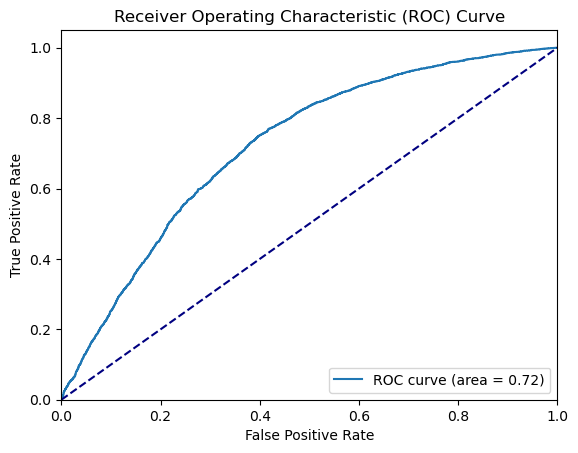

In [11]:
# 绘制ROC曲线
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()